In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import plotly.express as px
import cufflinks as cf
import psycopg2 as pg
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import chart_studio

# Display plots in Jupyter Notebook
%matplotlib inline

# Allow plotly to work in jupyter notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
cf.go_offline()

In [4]:
# Establish connection with plotly chart studio
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

PLOTLY_USER = os.environ.get("PLOTLY_USERNAME")

# (If this throws and error) Plotly site > Login > Account > API Key > Regenerate API Key
PLOTLY_API = os.environ.get("PLOTLY_API_KEY")

# Set the credentials
chart_studio.tools.set_credentials_file(username=PLOTLY_USER, api_key=PLOTLY_API)

import chart_studio.plotly as py
import chart_studio.tools as tls

In [5]:
# Connect to PostGre DB
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

# Connect to PostGre DB
engine = pg.connect(database='dfd9h7b5lvjt7g', user='whiazhrvmgwffw', host='ec2-52-48-159-67.eu-west-1.compute.amazonaws.com',
                    port='5432', password=os.environ.get('PROD_DATABASE_PASS'), sslmode='require')

# Gather all data and store into a pandas dataframe to be used for analysis
df = pd.read_sql('select * from reviews', engine)
engine.close()

In [6]:
# Take a look at the first few rows of the dataframe
df.head()

,id,course,date,overall_rating,job_prospects_rating,job_prospects_desc,course_lecturer_rating,course_lecturer_desc,facilities_rating,facilities_desc,student_support_rating,student_support_desc,local_life_rating,local_life_desc
0,179,MA Creative Writing,2021-11-04,4,4,N/A,3,Generally good. Some more supportive than othe...,4,Facilities are good. Generally clean. Quite a ...,4,Seems like there are things going on. Haven't ...,-1,N/A
1,180,Criminology and Social Policy BA (Hons),2021-05-28,5,5,I interacted with the Careers and Employabilit...,5,"1st year: You have 8 hours a week, 4 modules a...",5,"I haven't needed to hire equipment, however th...",5,I haven't accessed the SU services (only becau...,-1,N/A
2,181,Biology with Science Foundation Year BSc (Hons),2021-05-26,5,5,Consistent emails about job opportunities,4,Was effective but could be improved by adding ...,4,The uni itself is fairly professional with its...,3,"There has been an effort made, I acknowledge t...",-1,N/A
3,182,Politics and Social Policy BA (Hons),2021-05-26,4,4,N/A,4,Transition to online has been handled well. Co...,5,N/A,3,N/A,-1,N/A
4,183,Zoology BSc (Hons),2021-05-26,3,5,Placement and internship opportunities are adv...,3,It’s a real mix- some lecturers are very good ...,5,The labs are very well equipped and PhD studen...,4,"Student wellbeing services are very helpful, a...",-1,N/A


In [7]:
# Get some basic statistics about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      720 non-null    int64         
 1   course                  720 non-null    object        
 2   date                    720 non-null    datetime64[ns]
 3   overall_rating          720 non-null    int64         
 4   job_prospects_rating    720 non-null    int64         
 5   job_prospects_desc      720 non-null    object        
 6   course_lecturer_rating  720 non-null    int64         
 7   course_lecturer_desc    720 non-null    object        
 8   facilities_rating       720 non-null    int64         
 9   facilities_desc         720 non-null    object        
 10  student_support_rating  720 non-null    int64         
 11  student_support_desc    720 non-null    object        
 12  local_life_rating       720 non-null    int64     

In [8]:
# Checks for any null values
df.isnull().sum()

id                        0
course                    0
date                      0
overall_rating            0
job_prospects_rating      0
job_prospects_desc        0
course_lecturer_rating    0
course_lecturer_desc      0
facilities_rating         0
facilities_desc           0
student_support_rating    0
student_support_desc      0
local_life_rating         0
local_life_desc           0
dtype: int64

In [9]:
# Checks for any duplicate values
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
715    False
716    False
717    False
718    False
719    False
Length: 720, dtype: bool

In [10]:
# Show number of reviews per year
pd.to_datetime(df['date']).dt.year.value_counts()

2019    309
2020    133
2018    122
2017     93
2022     40
2021     23
Name: date, dtype: int64

In [11]:
"""
From the data gathered above we know that there are no null values and no duplicates
However questions to responses that have not been answered are marked as 'N/A'
Also ratings for un answered categories are marked as -1
There is also a a heavy amount of reviews in 2019 but very little in 2022 and 2021
This is important to keep in mind during analysis
"""

"\nFrom the data gathered above we know that there are no null values and no duplicates\nHowever questions to responses that have not been answered are marked as 'N/A'\nAlso ratings for un answered categories are marked as -1\nThere is also a a heavy amount of reviews in 2019 but very little in 2022 and 2021\nThis is important to keep in mind during analysis\n"

In [12]:
# Change un answered questions to from N/A to null
# Also change unaanswered ratings from -1 to null
# This makes it easier for calculations later on
df = df.applymap(lambda x: x if x!= -1 or x != 'N/A' else np.nanmean())

In [13]:
# Plot to find overall rating for the university of Lincoln over time
fig1 = px.scatter(df, x='date', y="overall_rating",
                 color = "overall_rating", trendline="ols",
                 labels={
                     "overall_rating": "Overall Rating (1-5)",
                     "date": "Date (years)"},
                 color_continuous_scale=px.colors.sequential.Plotly3)

fig1.layout.coloraxis.colorbar.title = 'Overall<br>Rating<br>'
fig1.update_layout(title_text='Overall Rating For The University of Lincoln Over Time', title_x=0.5)

fig1.show()

In [14]:
# Plot to find mean rating for different categories

# Update data frame names
df_changed = df.rename(columns={'job_prospects_rating': 'job prospects rating',
                   'course_lecturer_rating': 'course lecturer rating', 'facilities_rating':'facilities rating',
                   'student_support_rating':'student support rating', 'local_life_rating':'local life rating'}, errors='raise')

# Take columns we are interested in and stack them into column named 'category'
# This will allow us to group by category and calculate mean rating
dfm = pd.melt(df_changed, id_vars=["id", "course", "date", "overall_rating", "job_prospects_desc", "course_lecturer_desc", "facilities_desc", "student_support_desc", "local_life_desc"],
              value_vars=["job prospects rating", "course lecturer rating", "facilities rating", "student support rating", "local life rating"],
              var_name ='Category')

# Group by category and calculate mean rating
dfg = dfm.groupby(['Category']).mean().reset_index()

# Plot a bar chart to show mean rating for different categories
fig2 = px.bar(dfg, x = 'Category', y = 'value', color = 'Category',
             category_orders = {'Category':['job prospects rating','course lecturer rating','facilities rating','student support rating','local life rating']})

fig2.update_layout(title_text='Mean Rating For Different Student Categories At The University of Lincoln', title_x=0.5)

fig2.update_yaxes(title = 'Mean rating (1-5)')
fig2.show()

In [42]:
# Plot to find meaning overall rating per course
"""Notes
This inst a very effective plot as many courses have only 1 or few reviews compared to other courses
that have many. This can impact the plot as you may have 1 course with 1 review of 5 stars, resulting in a mean
of 5, however on actual fact the course might not be great and being skewed by the view of 1 person.
This is something to consider and thats why we add the option to see the number of reviews per course also
"""

mean_rating_per_course = df.groupby('course', as_index=False)['overall_rating'].mean()    # Group by course and calculate mean rating
course_total_reviews = df['course'].value_counts()    # Counts the number of reviews per course

# Convert series to dataframe
course_total_reviews = pd.DataFrame(course_total_reviews)
course_total_reviews = course_total_reviews.reset_index()
course_total_reviews.columns = ['course', 'review_count']

# Merge the two data frames to get a single data frame with mean overall rating and review count per course
final_df = pd.merge(mean_rating_per_course, course_total_reviews, on='course', how='left')

fig3 = px.scatter(final_df, x='overall_rating', y="course",
                 color = "overall_rating",
                 labels={
                     "overall_rating": "Mean Overall Rating (1-5)",
                     "course": "Course"},
                 custom_data=['review_count'],
                 color_continuous_scale=px.colors.sequential.Plotly3)

fig3.layout.coloraxis.colorbar.title = 'Overall<br>Rating<br>'
fig3.update_layout(title_text='Mean Overall Rating For Courses From The University of Lincoln', title_x=0.5)
fig3.update_traces(
                hovertemplate='<br>'.join([
                    'Course: %{y}',
                    'Mean Overall Rating: %{x}',
                    'Num of Reviews: %{customdata}',
                ]))
fig3.update_yaxes(visible=False, showticklabels=False)

fig3.show()



In [43]:
# Upload the plots to plotly chart studio (Check plotly.chartstudio website > My Files)
"""
py.plot(fig1, filename='Overall Rating For The University of Lincoln Over Time', auto_open=False)
py.plot(fig2, filename='Mean Rating For Different Student Categories At The University of Lincoln', auto_open=False)
py.plot(fig3, filename='Mean Overall Rating For Courses From The University of Lincoln', auto_open=False)
"""

'https://plotly.com/~mathewsjoyy/8/'

In [ ]:
# Define a function to plot word cloud for later use
def plot_word_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(20,10))
    # Display image
    plt.imshow(wordcloud, interpolation="bilinear") 
    # No axis details
    plt.axis("off")
    # Save the image to current local directory
    plt.savefig("./fig.png", dpi=300, format="png")
    
# Add stop words to the list of words to be removed
STOPWORDS.add("want")
STOPWORDS.add("N")
STOPWORDS.add("great")

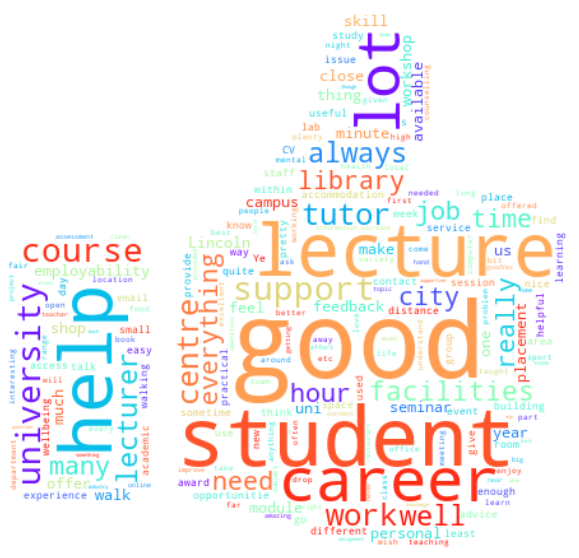

In [ ]:
# Wordcloud to find the most common words in the reviews with a overall rating above (or equal to) 4 (Positive)
df_pos = df[df['overall_rating'] >= 4]

columns = ["job_prospects_desc", "course_lecturer_desc", "facilities_desc", "student_support_desc", "local_life_desc"]

# Join together all the comments in the reviews that have a overall rating above (or equal to) 4 (Positive)
all_pos_reviews = ' '.join(df_pos[columns].fillna('').sum(axis=1))

# Import image to np.array
mask = np.array(Image.open('./masking_images/upvote.png'))

# Generate word cloud
wordcloud1 = WordCloud(width = 1000, height = 1000, random_state=1, background_color='white',
                      colormap='rainbow', collocations=False, stopwords = STOPWORDS,
                      mask=mask).generate(all_pos_reviews)

# Plot the word cloud
plot_word_cloud(wordcloud1)

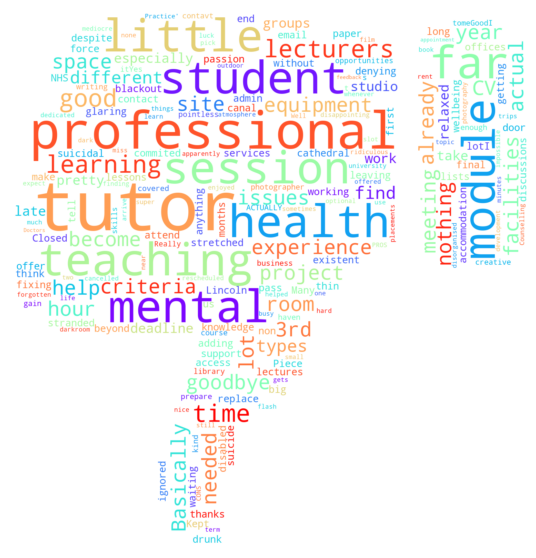

In [ ]:
# Wordcloud to find the most common words in the reviews with a overall rating below 2 (Negative)
df_pos = df[df['overall_rating'] < 2]

columns = ["job_prospects_desc", "course_lecturer_desc", "facilities_desc", "student_support_desc", "local_life_desc"]

# Join together all the comments in the reviews
all_neg_reviews = ' '.join(df_pos[columns].fillna('').sum(axis=1))

# Import image to np.array
mask = np.array(Image.open('./masking_images/downvote.png'))

# Generate word cloud
wordcloud2 = WordCloud(width = 1000, height = 1000, random_state=1, background_color='white',
                      colormap='rainbow', collocations=False, stopwords = STOPWORDS,
                      mask=mask).generate(all_neg_reviews)

# Plot the word cloud
plot_word_cloud(wordcloud2)